# Проект по распознаванию фамилий


Ваша команда разрабатывает продукт для распознавания документов. В качестве одной из подзадач, возникших в этом проекте, нужно построить классификатор, который по фрагменту текста сможет определить, насколько вероятно, что этот текст - чья-то фамилия.

Для оценки качества решено использовать площадь под ROC-кривой (AUC), учитывайте это при подготовке прогноза на тестовой выборке.

В этом соревновании вам предстоит решить обычную задачу бинарной классификации, но признаки вам понадобится извлечь из примеров самостоятельно. В вашем распоряжении обучающая выборка, тестовая (на ней нужно спрогнозировать ответы) и пример файла с прогнозами. В примере прогнозов есть некоторый подвох, который специально может ввести вас в заблуждение, но если вы помните, как вычисляется ROC-AUC, вы на него не попадётесь :)

Описание файлов:

linear_train.txt - обучающая выборка

linear_test.txt - тестовая выборка

linear_ans_example.txt - пример файла с прогнозами

Точность разметки данных
Разметка датасета была частично автоматизирована, поэтому некоторые "фамилии" из выборки могут вас очень удивить. К сожалению, с этой проблемой часто приходится иметь дело при работе с "грязными" данными. В рамках этого задания вам нужно считать разметку выборки идеальной. С одной стороны, вам не нужно думать, как вычистить выборку. С другой стороны, это приведет к тому, что какие-то действительно хорошие идеи признаков могут не заработать.

### 1. Импортируем необходимые библиотеки

In [ ]:
import numpy as np
import pandas as pd
        
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1)  

from sklearn import tree
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.preprocessing import OneHotEncoder

from gensim.models import Word2Vec

### 2. Прочитаем файлы, обработаем данные.

In [ ]:
surname_test = pd.read_csv('linear_test.txt', header = None, names=['surname'])
surname_data = pd.read_csv('linear_train.txt', header = None, names=['surname', 'answer'])

In [ ]:
surname_test.head(5)

,surname
0,Аалто
1,ААР
2,Аара
3,Ааре
4,Аарон


Напишем небольшие функции, которые пригодятся для создания новых признаков.

In [ ]:
print("Train", surname_data.shape)
print("Test", surname_test.shape)

Train (101408, 2)
Test (188920, 1)


In [ ]:
okonchanie = ['ин', 'ын','ов','ев','ан','ой','их','ых', 'ен','ина', 'ына','ова','ева','ких','ая','чик','ски','дзе','ина'\
             'шин', 'кин', 'нко', 'йко', 'ко', 'кий', 'кая', 'тти','ез','ес','лло','сон','ерг','ис', 'ом','ерс','рс'\
             'ной','ным','вой','вым','ном','ой','ым','ом','кой','ким','им']
glacnie = ['у', 'е', 'а', 'ы', 'о', 'э', 'я', 'и', 'ю', 'ё' ]
soglas = ['й','ц','к','н','г','ш','щ','з','х','ф','в','п','р','л','д','ж','ч','с','м','т','б']
znak = ['ь', 'ъ']

def kol_glas(st):  
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] in glacnie:
            k+=1
    return k   

def kol_soglas(st):  
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] in soglas:
            k+=1
    return k

def znaki(st):
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] in znak:
            k+=1
    return k 

def a(st):
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] == 'а':
            k+=1
    return k

def povtor(st):
    k = 0
    st = st.lower()
    for i in range(len(st)-1):
        if st[i] == st[i+1]:
            k+=1
    return k 

def n(st):
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] == 'н':
            k+=1
    return k

def m(st):
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] == 'м':
            k+=1
    return k

В тренировочном и тестовом датасетах создадим дополнительные признаки.

In [ ]:
for df in [surname_data, surname_test]:
    df['kol_bukw'] = [len(element) for element in df.surname]                       # Количество элементов
    df['glasnie'] = [kol_glas(element) for element in df.surname]                   # Количество гласных букв
    df['soglasnie'] = [kol_soglas(element) for element in df.surname]               # Количество согласных букв
    df['lower'] = [np.where( element.islower(),1,0) for element in df.surname]
    df['lower'] = df.lower.astype(int)                                              # Нижний регистр
    df['upper'] = [np.where( element.isupper(),1,0) for element in df.surname]
    df['upper'] = df.upper.astype(int)                                              # Верхний регистр
    df['title'] = [np.where( element.istitle(),1,0) for element in df.surname]
    df['title'] = df.title.astype(int)                                              # Начинается с большой буквы
    df['okon2'] = [element[-2:].lower() for element in df.surname]                  
    df['okon3'] = [element[-3:].lower() for element in df.surname]                  
    df['okon2'] = np.where(df.okon2.isin(okonchanie),1,0)                           # Две последние буквы являются окончанием фамилий
    df['okon3'] = np.where(df.okon3.isin(okonchanie),1,0)                           # Три последние буквы являются окончанием фамилий
    df['symbols'] = [element.count("«")+element.count("»")+element.count('“')       # Количество специальных символов
                 +element.count('”')+element.count('-') for element in df.surname]
    df['znaki'] = [znaki(element) for element in df.surname]                        # Количество твердых и мягких знаков
    df['probel'] = [element.count(' ') for element in df.surname]                   # Количество пробелов
    df['a'] = [a(element) for element in df.surname]                                # Количество буквы "а"
    df['povtory'] = [povtor(element) for element in df.surname]                     # Посторяющиеся друг за другом буквы
    df['nm'] = [n(element)+m(element) for element in df.surname]                    # Количество букв м и н
    df['szp'] = df.symbols*df.znaki*df.probel
    df['okonchanie'] = [element[-3:].lower() for element in df.surname]

In [ ]:
o = np.array(surname_data.okonchanie.value_counts().head(50).index.tolist())   # 50 самых частых окончаний, которые будут закодированы методом one hot encoding

In [ ]:
surname_data.head(5)

,surname,answer,kol_bukw,glasnie,soglasnie,lower,upper,title,okon2,okon3,symbols,znaki,probel,a,povtory,nm,szp,okonchanie
0,Аалтонен,1,8,4,4,0,0,1,1,0,0,0,0,2,1,2,0,нен
1,Аар,0,3,2,1,0,0,1,0,0,0,0,0,2,1,0,0,аар
2,Аарон,0,5,3,2,0,0,1,0,0,0,0,0,2,1,1,0,рон
3,ААРОН,0,5,3,2,0,1,0,0,0,0,0,0,2,1,1,0,рон
4,Аарона,0,6,4,2,0,0,1,0,0,0,0,0,3,1,1,0,она


Посмотрим на получившиеся признаки.

In [ ]:
surname_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101408 entries, 0 to 101407
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   surname     101408 non-null  object
 1   answer      101408 non-null  int64 
 2   kol_bukw    101408 non-null  int64 
 3   glasnie     101408 non-null  int64 
 4   soglasnie   101408 non-null  int64 
 5   lower       101408 non-null  int64 
 6   upper       101408 non-null  int64 
 7   title       101408 non-null  int64 
 8   okon2       101408 non-null  int64 
 9   okon3       101408 non-null  int64 
 10  symbols     101408 non-null  int64 
 11  znaki       101408 non-null  int64 
 12  probel      101408 non-null  int64 
 13  a           101408 non-null  int64 
 14  povtory     101408 non-null  int64 
 15  nm          101408 non-null  int64 
 16  szp         101408 non-null  int64 
 17  okonchanie  101408 non-null  object
dtypes: int64(16), object(2)
memory usage: 13.9+ MB


### 3. Визуальный анализ

Посмотрим графики распределения некоторых переменных и корреляцию.

In [ ]:
non_binary = ['kol_bukw', 'glasnie', 'soglasnie','symbols', 'znaki', 'probel','a']         # Не двоичные признаки

Построим матрицу корреляции. С целевым признаком ничего не коррелирует, однако есть сильная корреляция количества букв и количества согласных. Удалять признаки пока не будем.

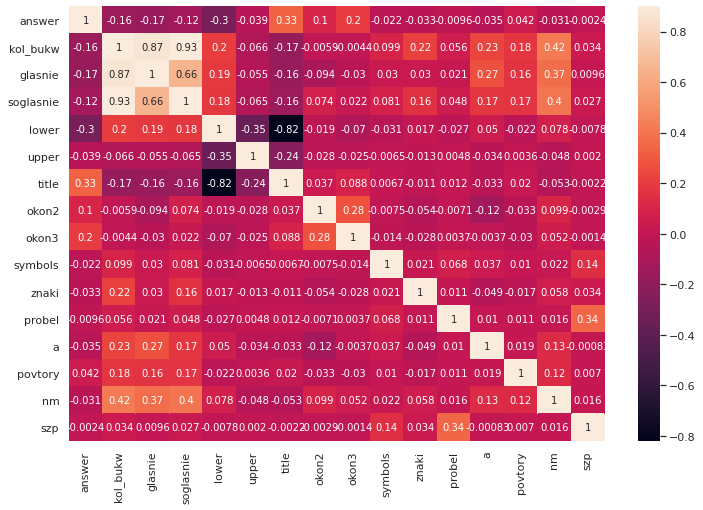

In [ ]:
plt.figure(figsize=(12,8))
corrMatrix = surname_data.corr()
sns.heatmap (corrMatrix, annot = True, vmax=0.9)

Для не двоичных признаков построим графики распределения.

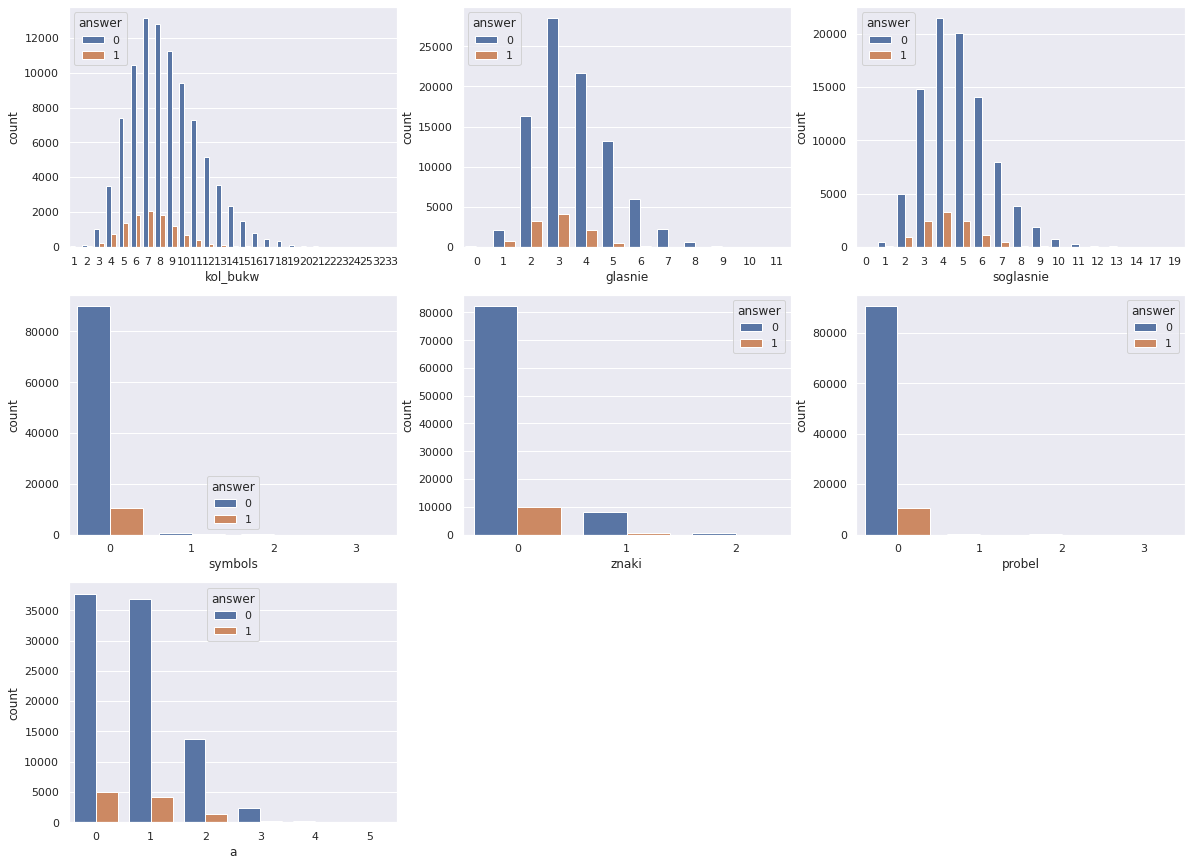

In [ ]:
plt.figure(figsize = (20,15))
for idx,col in enumerate(surname_data[non_binary]):
    plt.subplot(3,3,idx+1)
    sns.countplot(x=surname_data[col], hue=surname_data.answer)
None

Стали видны некоторые закономерности, например в фамилиях количество букв не больше 14, почти отсутствуют пробелы и другие символы (что вполне логично).

Посмотрим на столбец ответов. Видно, что данные не сбалансированные, поэтому для оценки качества применяется roc_auc.

In [ ]:
surname_data.answer.value_counts()

0    90770
1    10638
Name: answer, dtype: int64

### 4. Использование модели векторного представления

Чтобу продолжить работу, переведем каждое слово в векторное представление с помощью word2vec.

In [ ]:
def break_3(st):
    a = [st[-x:].lower() for x in range(2, 5)]
    b = [st[x:x+3].lower() for x in range(0, len(st), 3)]
    return a+b

Cоздадим тексты необходимые для обучения word2vec

In [ ]:
for df in [surname_data, surname_test]:
    df['words']= [break_3(element) for element in df.surname]

In [ ]:
model = Word2Vec(list(pd.concat([surname_data.words, surname_test.words], axis=0)), size=50, window=5, workers=4)
#создадим словарь со словами и соответсвующими им векторами
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
class mean_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(w2v.values())))

    def fit(self, X):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [ ]:
data_mean_train=mean_vectorizer(w2v).fit(surname_data['words']).transform(surname_data['words'])
data_mean_train.shape

(101408, 50)

In [ ]:
data_mean_test=mean_vectorizer(w2v).fit(surname_test['words']).transform(surname_test['words'])
data_mean_test.shape

(188920, 50)

Соберем датасеты для обучения и предсказания.

In [ ]:
data_mean_train = pd.DataFrame(data_mean_train)
data_mean_test = pd.DataFrame(data_mean_test)

data_train = pd.concat([surname_data,data_mean_train], axis=1)
data_test = pd.concat([surname_test,data_mean_test], axis=1)

One hot encoding колонки окончаний.

In [ ]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [ ]:
ohe.fit(o.reshape(-1, 1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=False)

In [ ]:
ohe.get_feature_names()

array(['x0_ами', 'x0_дом', 'x0_ели', 'x0_ель', 'x0_ера', 'x0_ией',
       'x0_ием', 'x0_ика', 'x0_ике', 'x0_ики', 'x0_ику', 'x0_ина',
       'x0_иям', 'x0_иях', 'x0_кам', 'x0_ках', 'x0_ков', 'x0_кой',
       'x0_ком', 'x0_лей', 'x0_лем', 'x0_ние', 'x0_нии', 'x0_ний',
       'x0_ник', 'x0_нию', 'x0_ния', 'x0_нов', 'x0_ном', 'x0_ова',
       'x0_она', 'x0_ора', 'x0_рам', 'x0_рах', 'x0_ров', 'x0_ром',
       'x0_сом', 'x0_сти', 'x0_сть', 'x0_там', 'x0_тах', 'x0_тва',
       'x0_тво', 'x0_тов', 'x0_том', 'x0_тью', 'x0_ции', 'x0_цию',
       'x0_ция', 'x0_ями'], dtype=object)

In [ ]:
ohe_train = pd.DataFrame(ohe.transform(np.array(data_train.okonchanie).reshape(-1, 1)), columns=ohe.get_feature_names())
ohe_test = pd.DataFrame(ohe.transform(np.array(data_test.okonchanie).reshape(-1, 1)),columns=ohe.get_feature_names())

ohe_train.shape, ohe_test.shape

((101408, 50), (188920, 50))

In [ ]:
data_train = pd.concat([data_train,ohe_train], axis=1)
data_test = pd.concat([data_test,ohe_test], axis=1)

Подготовка тестовой выборки

In [ ]:
test = data_test.drop(['surname','words','okonchanie'], axis=1)

In [ ]:
test.head(5)

,kol_bukw,glasnie,soglasnie,lower,upper,title,okon2,okon3,symbols,znaki,probel,a,povtory,nm,szp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,x0_ику,x0_ина,x0_иям,x0_иях,x0_кам,x0_ках,x0_ков,x0_кой,x0_ком,x0_лей,x0_лем,x0_ние,x0_нии,x0_ний,x0_ник,x0_нию,x0_ния,x0_нов,x0_ном,x0_ова,x0_она,x0_ора,x0_рам,x0_рах,x0_ров,x0_ром,x0_сом,x0_сти,x0_сть,x0_там,x0_тах,x0_тва,x0_тво,x0_тов,x0_том,x0_тью,x0_ции,x0_цию,x0_ция,x0_ями
0,5,3,2,0,0,1,0,0,0,0,0,2,1,0,0,0.483968,0.548936,1.233367,-1.581501,0.870962,1.409171,-0.169767,-1.584975,1.832636,0.228065,0.273658,0.539722,-0.689115,0.919823,0.605173,0.492508,0.700842,0.643364,-0.272268,0.012002,0.167066,-0.350977,0.522308,0.440822,-0.239357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,2,1,0,1,0,0,0,0,0,0,2,1,0,0,0.642142,0.430525,0.203242,-0.707267,-0.230751,0.478095,0.219927,0.759180,0.451031,0.257471,-0.526019,0.349884,-0.209531,0.421649,-0.511936,0.281543,-0.221907,0.971400,-0.028763,0.506727,0.078176,0.175591,-0.246192,-0.560041,-0.304089,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,3,1,0,0,1,0,0,0,0,0,3,1,0,0,0.285298,0.089477,-0.561397,-2.733277,0.250223,-0.716004,1.279646,0.551260,1.697739,-0.024553,-0.444936,1.460243,0.139552,-0.915337,-0.963369,-0.645045,0.163560,0.754225,0.567242,-0.228528,0.474065,0.093574,0.080129,-0.022854,-0.435966,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,3,1,0,0,1,0,0,0,0,0,2,1,0,0,0.163074,2.097343,0.590736,-1.910834,0.555223,0.096452,-0.086241,-0.365527,1.242443,0.115608,-0.387782,0.160217,-0.725881,-0.340190,-1.668943,-0.867897,1.217994,-0.269108,1.198016,2.689241,1.017020,0.852885,0.449242,-1.370059,-0.061640,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,3,2,0,0,1,0,0,0,0,0,2,1,1,0,0.549131,0.632139,-0.173013,-1.493371,-1.573351,1.217565,0.593016,-0.555590,3.569676,2.185325,0.792358,0.793576,-2.249596,0.855420,0.469863,0.813295,0.501683,1.341190,0.210996,0.401511,0.888843,1.014279,-0.363563,-0.082485,0.977776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 5. Обучение модели
Подготовка данных для обучения

In [ ]:
X, y = data_train.drop(['surname','words', 'answer','okonchanie'], axis=1), data_train['answer']

Для оценки качества модели воспользуемся разбиением на обучающую и тестовую выборки.

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)  # stratify используется для того, чтобы сохранялся баланс классов

X_tr.shape,X_val.shape,y_tr.mean(),y_val.mean()


((70985, 115), (30423, 115), 0.1049094879199831, 0.10488774940012491)

В качестве модели будет использован градиентный бустинг XGBoost

In [ ]:
eval_set=[(X_tr, y_tr.values.ravel()), (X_val, y_val.values.ravel())]

In [ ]:
xgb = XGBClassifier(max_depth=8, scoring= 'roc_auc', random_state=42)

In [ ]:
%%time
xgb.fit(X_tr, y_tr.values.ravel(),eval_metric=["error", "logloss"],  eval_set=eval_set, verbose=False, early_stopping_rounds=10)

CPU times: user 1min 20s, sys: 264 ms, total: 1min 20s
Wall time: 1min 20s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, scoring='roc_auc',
              seed=None, silent=None, subsample=1, verbosity=1)

Отрисуем график ошибок.

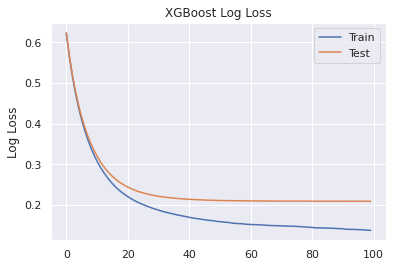

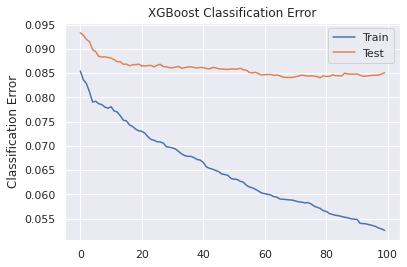

In [ ]:
# retrieve performance metrics
results = xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [ ]:
y_pred_train = xgb.predict_proba(X_tr)[:,1]

y_pred = xgb.predict_proba(X_val)[:,1]

In [ ]:
train_auc = roc_auc_score(y_tr, y_pred_train)
test_auc = roc_auc_score(y_val, y_pred)

In [ ]:
print("ROC AUC на трейне:",train_auc)
print("ROC AUC на тесте:",test_auc)

ROC AUC на трейне: 0.972657979715876
ROC AUC на тесте: 0.9041507751125833


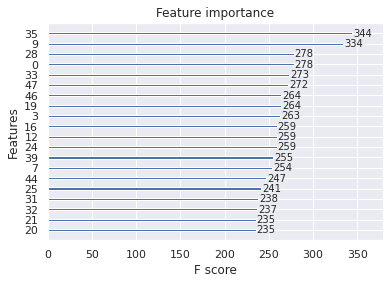

In [ ]:
plot_importance(xgb,  max_num_features= 20)

Изобразим roc auc

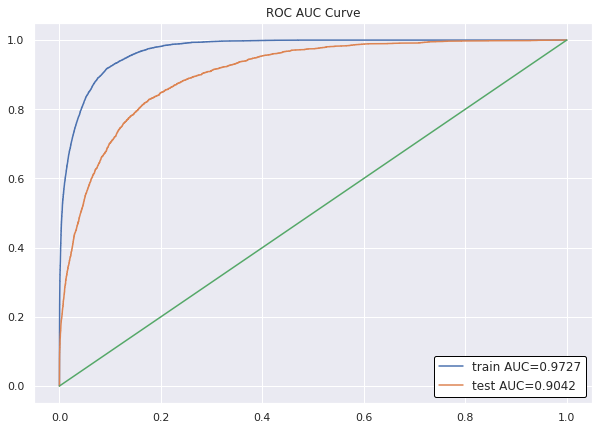

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_tr, y_pred_train)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_val, y_pred)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.title('ROC AUC Curve')
plt.show()

В этой работе я не буду использовать поиск по сетке гиперпараметров, потому что это очень долго. Вместо этого я вручную подобрала глубину дерева, количество оценщиков и learning rate чтобы добиться максимального результата.

### 6. Получение результатов

In [ ]:
xgb.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, scoring='roc_auc',
              seed=None, silent=None, subsample=1, verbosity=1)

Получим результаты для нашего теста

In [ ]:
y_predicted_prob = xgb.predict_proba(test)[:,1]
y_predicted_prob

array([0.50095636, 0.1529927 , 0.43076387, ..., 0.01413305, 0.00326623,
       0.00309742], dtype=float32)

In [ ]:
y = pd.DataFrame(y_predicted_prob, index =None)
y = y.rename(columns={0: "Answer"})
y = y.rename_axis('Id')
y.head(5)

,Answer
Id,
0,0.500956
1,0.152993
2,0.430764
3,0.383363
4,0.211942


Сохраним в файл csv.

In [ ]:
y.to_csv('surname_solver.csv')

На kaggle удалось достичь результата 0.90705 по roc auc.